# 시작

**필요한 라이브러리 불러오기**

In [2]:
!pip install konlpy

In [3]:
import pandas as pd
import numpy as np
import re
from konlpy.tag import Okt,Mecab
from keras.preprocessing.text import Tokenizer, one_hot

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score,f1_score

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**데이터 불러오기**

In [5]:
train      = pd.read_csv("/content/drive/MyDrive/Dacon/뉴스 토픽 분류 AI 경진대회/data/train_data.csv")
test       = pd.read_csv("/content/drive/MyDrive/Dacon/뉴스 토픽 분류 AI 경진대회/data/test_data.csv")
submission = pd.read_csv("/content/drive/MyDrive/Dacon/뉴스 토픽 분류 AI 경진대회/data/sample_submission.csv")
topic_dict = pd.read_csv("/content/drive/MyDrive/Dacon/뉴스 토픽 분류 AI 경진대회/data/topic_dict.csv")

**데이터 전처리**

In [6]:
# 형태소 분석기(Okt) 불러오기 
okt=Okt() 

In [ ]:
# 조사, 어미, 구두점 제거
def func(text):
    clean = []
    for word in okt.pos(text, stem=True): #어간 추출
        if word[1] not in ['Josa', 'Eomi', 'Punctuation']: #조사, 어미, 구두점 제외 
            clean.append(word[0])
    
    
    return " ".join(clean) 

train['title'] = train['title'].apply(lambda x : clean_text(x))

KeyboardInterrupt: ignored

In [6]:
stop_words = [ '은', '는', '이', '가', '하', '아', '것', '들','의', '있', '되', '수', '보', '주', '등', '한']
okt = Okt()

def clean_text(sent, okt, remove_stopwords = False, stop_words = []):
  sent_clean = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", " ", sent)
  
  word_sent = okt.morphs(sent_clean, stem=True)
    
  if remove_stopwords:
        
        # 불용어 제거(선택적)
    word_set = [token for token in word_sent if not token in stop_words]
    
  return word_sent

clean_train_review = []

for review in train['title']:
    # 비어있는 데이터에서 멈추지 않도록 string인 경우만 진행
    if type(review) == str:
        clean_train_review.append(clean_text(review, okt, remove_stopwords = True, stop_words=stop_words))
    else:
        clean_train_review.append([])  #string이 아니면 비어있는 값 추가

clean_test_review = []

for review in test['title']:
    # 비어있는 데이터에서 멈추지 않도록 string인 경우만 진행
    if type(review) == str:
        clean_test_review.append(clean_text(review, okt, remove_stopwords = True, stop_words=stop_words))
    else:
        clean_test_review.append([])  #string이 아니면 비어있는 값 추가


In [8]:
stop_words = [ '은', '는', '이', '가', '하', '아', '것', '들','의', '있', '되', '수', '보', '주', '등', '한', '화', '철']
okt = Okt()

def clean_text(sent, okt, remove_stopwords = False, stop_words = []):
  sent_clean = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", " ", sent)
  
  word_sent = okt.morphs(sent_clean, stem=True)
    
  if remove_stopwords:
        
        # 불용어 제거(선택적)
    word_set = [token for token in word_sent if not token in stop_words]
    
  return word_sent

train["cleaned_title"] = train["title"].apply(lambda x : clean_text(x, okt, remove_stopwords= True, stop_words= stop_words))
test["cleaned_title"]  = test["title"].apply(lambda x : clean_text(x, okt, remove_stopwords= True, stop_words= stop_words))

In [10]:
train

,index,title,topic_idx,cleaned_title
0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4,"[인천, 핀란드, 항공기, 결항, 휴가, 철, 여행객, 분통]"
1,1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4,"[실리콘밸리, 넘어서다, 구글, 조원, 들이다, 전역, 거점, 화]"
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4,"[이란, 외무, 긴장, 완화, 해결, 책, 은, 미국, 이, 경제, 전쟁, 멈추다, 것]"
3,3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4,"[클린턴, 측근, 기업, 특수, 관계, 조명, 공과, 사, 맞다, 물리다, 종합]"
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4,"[시진핑, 트럼프, 에, 중미, 무역, 협상, 조속, 타결, 희망]"
...,...,...,...,...
45649,45649,KB금융 미국 IB 스티펠과 제휴…선진국 시장 공략,1,"[금융, 미국, 스티펠, 과, 제휴, 선진국, 시장, 공략]"
45650,45650,1보 서울시교육청 신종코로나 확산에 개학 연기·휴업 검토,2,"[보, 서울시, 교육청, 신종, 코로나, 확산, 에, 개학, 연기, 휴업, 검토]"
45651,45651,게시판 키움증권 2020 키움 영웅전 실전투자대회,1,"[게시판, 키우다, 증권, 키우다, 영웅, 전, 실전, 투자, 대회]"
45652,45652,답변하는 배기동 국립중앙박물관장,2,"[답변, 하다, 배, 기동, 국립, 중앙, 박물관, 장]"


In [11]:
train_text = train["cleaned_title"].tolist()
test_text = test["cleaned_title"].tolist()
train_label = np.asarray(train.topic_idx)

train_text

[['인천', '핀란드', '항공기', '결항', '휴가', '철', '여행객', '분통'],
 ['실리콘밸리', '넘어서다', '구글', '조원', '들이다', '전역', '거점', '화'],
 ['이란', '외무', '긴장', '완화', '해결', '책', '은', '미국', '이', '경제', '전쟁', '멈추다', '것'],
 ['클린턴', '측근', '기업', '특수', '관계', '조명', '공과', '사', '맞다', '물리다', '종합'],
 ['시진핑', '트럼프', '에', '중미', '무역', '협상', '조속', '타결', '희망'],
 ['팔레스타인', '가자지구', '서', '세', '소년', '이스라엘군', '총격', '에', '사망'],
 ['인도', '년', '만에', '파키스탄', '공습', '테러', '캠프', '폭격', '종합', '보'],
 ['대선',
  '토론',
  '음담패설',
  '만회',
  '실패',
  '트럼프',
  '사과',
  '대신',
  '빌다',
  '클린턴',
  '공격',
  '하다',
  '역효과'],
 ['푸틴', '한반도', '상황', '진전', '위', '한', '방안', '김정은', '위원장', '과', '논의'],
 ['특검', '면죄부', '받다', '트럼프', '스캔들', '보도', '언론', '맹공', '국민', '의', '적'],
 ['오키나와', '서', '열리다', '강제', '징용', '노동자', '추도', '식'],
 ['이란', '서', '최고', '지도자', '모욕', '혐의', '미국인', '에', '징역', '년', '선고'],
 ['카니발', '축제', '보다', '가다', '브라질', '리우', '에', '대형', '유람선', '행렬'],
 ['올랜도', '병원', '최악', '총기', '테러', '부상', '자', '치료', '비', '안', '받다'],
 ['대기업', '올해', '평균', '임금', '인상'],
 ['엘니뇨', '여전하다', '강력', '

In [7]:
stop_words = [ '은', '는', '이', '가', '하', '아', '것', '들','의', '있', '되', '수', '보', '주', '등', '한']
def tokenizer(raw_texts, pos=["Noun","Alpha","Verb","Number"], stop_words = stop_words):
    p = okt.pos(raw_texts, 
            norm=True,   # 정규화(normalization)
            stem=True    # 어간추출(stemming)
            )
    o = [word for word, tag in p if len(word) > 1 and tag in pos and word not in stop_words]
    return(o)

#tfidf = TfidfVectorizer(analyzer='word', sublinear_tf=True, ngram_range=(1, 2), max_features=130, binary=False)

#tfidf.fit(train_text)

#train_tf_text = tfidf.transform(train_text).astype('float32')
#test_tf_text  = tfidf.transform(test_text).astype('float32')

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorize = TfidfVectorizer(
    tokenizer=tokenizer, # 문장에 대한 tokenizer (위에 정의한 함수 이용)
    min_df=1,            # 단어가 출현하는 최소 문서의 개수
    sublinear_tf=True,
    binary = False,
    analyzer='word',
    ngram_range=(1,2)    # tf값에 1+log(tf)를 적용하여 tf값이 무한정 커지는 것을 막음
)

X = vectorize.fit_transform(train['title'])
X.toarray() 

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(min_df=0)
tfidf_vectorizer = tfidf.fit_transform(train['title']) 


#https://www.titanwolf.org/Network/q/478b0785-0362-4267-90f2-dbfbdf2652e2/y
# 'list' object has no attribute 'lower' 위는 이 에러 참고용 
#tf-idf dictionary    
tfidf_dict = tfidf.get_feature_names()
print(tfidf_dict)
print(tfidf_vectorizer.toarray())

AttributeError: ignored

In [ ]:
# train/valid 데이터 셋 나누기.
def split_dataset(tfidf,df):
    X_data = tfidf
    y_data = df['topic_idx']

    # stratify=y_data Stratified 기반 분할, train 데이터의 30%를 평가 데이터 셋으로 사용. (70% 데이터 학습에 사용)
    X_train, X_test, y_train, y_test = \
    train_test_split(X_data, y_data, test_size=0.3, random_state=42, stratify=y_data)

    
    return (X_train, X_test, y_train, y_test)

X_train, X_test, y_train, y_test = split_dataset(tfidf_matrix_train,train)

**Model**

In [ ]:
estimator = SVC(kernel= 'rbf')

param_grid = {'C': [0.01, 0.1, 1, 10],
              'gamma': [0.01, 0.1, 1, 10]}

grid = RandomizedSearchCV(estimator, param_grid, cv=5, scoring = 'accuracy', verbose = 1)

grid.fit(X_train,y_train)

print('Best parameters:', grid.best_params_)

#Best parameters: {'gamma': 1, 'C': 1}

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 144.1min finished


Best parameters: {'gamma': 1, 'C': 1}


##SVC

In [ ]:
svc = SVC(kernel='rbf', 
          gamma = 1,
          C = 1)
svc.fit(X_train,y_train)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [ ]:
pred = svc.predict(X_test)
accuracy = accuracy_score(y_test,pred)

print('정확도', accuracy)

정확도 0.7402350879754691


In [ ]:
test['title'] = test['title'].apply(lambda x : func(x)) 

tfidf_matrix_test = tfidf_vect.transform(test['title'])

pred = svc.predict(tfidf_matrix_test)

NameError: ignored

## LGBM

In [ ]:
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier


estimator = LGBMClassifier(objective='multiclass')

param_grid = {
    'learning_rate': [0.05,0.1,0.01,0.25,0.5],
    'max_depth': [20,50,100,200],
    'num_leaves': [50,100,200,300,500]
}

grid = GridSearchCV(estimator, param_grid, cv=5, scoring = 'accuracy', verbose = 1)

grid.fit(X_train, y_train)

print('Best parameters:', grid.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


In [ ]:
lgbm = LGBMClassifier(n_estimators = 1000,
                     objective = 'multiclass')

lgbm.fit(X_train, y_train,
        early_stopping_rounds = 100,
        verbose = 1)

In [ ]:
test['title'] = test['title'].apply(lambda x : func(x)) 

tfidf_matrix_test = tfidf_vect.transform(test['title'])

pred1 = lgbm.predict(tfidf_matrix_test)

## LSTM

In [ ]:
# 밑에서 예측한것 가져온거 topic이 예측한거 가져온것임

pred2 = topic
pred2

In [ ]:
submission['topic_idx'] = pred
submission.head()

,index,topic_idx
0,45654,3
1,45655,3
2,45656,2
3,45657,2
4,45658,3


In [ ]:
submission.to_csv('/content/drive/MyDrive/Dacon/뉴스 토픽 분류 AI 경진대회/submission/g1_c1_svc.csv', index=False)

# 책보고

In [ ]:
import numpy as np
import pandas as pd
import re
import json
from konlpy.tag import Okt
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.preprocessing.text import Tokenizer


In [ ]:
train      = pd.read_csv("/content/drive/MyDrive/Dacon/뉴스 토픽 분류 AI 경진대회/data/train_data.csv")
test       = pd.read_csv("/content/drive/MyDrive/Dacon/뉴스 토픽 분류 AI 경진대회/data/test_data.csv")
submission = pd.read_csv("/content/drive/MyDrive/Dacon/뉴스 토픽 분류 AI 경진대회/data/sample_submission.csv")
topic_dict = pd.read_csv("/content/drive/MyDrive/Dacon/뉴스 토픽 분류 AI 경진대회/data/topic_dict.csv")

In [ ]:
type(train['title'])

pandas.core.series.Series

In [ ]:
review_text = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", "", train['title'][0]) 
print(review_text)

인천핀란드 항공기 결항휴가철 여행객 분통


In [ ]:
stop_words = [ '은', '는', '이', '가', '하', '아', '것', '들','의', '있', '되', '수', '보', '주', '등', '한']
okt = Okt()

In [ ]:
def clean_text(sent, okt, remove_stopwords = False, stop_words = []):
  sent_clean = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", " ", sent)
  
  word_sent = okt.morphs(sent_clean, stem=True)
    
  if remove_stopwords:
        
        # 불용어 제거(선택적)
    word_set = [token for token in word_sent if not token in stop_words]
    
  return word_sent


clean_train_review = []

for review in train['title']:
    # 비어있는 데이터에서 멈추지 않도록 string인 경우만 진행
    if type(review) == str:
        clean_train_review.append(clean_text(review, okt, remove_stopwords = True, stop_words=stop_words))
    else:
        clean_train_review.append([])  #string이 아니면 비어있는 값 추가

clean_test_review = []

for review in test['title']:
    # 비어있는 데이터에서 멈추지 않도록 string인 경우만 진행
    if type(review) == str:
        clean_test_review.append(clean_text(review, okt, remove_stopwords = True, stop_words=stop_words))
    else:
        clean_test_review.append([])  #string이 아니면 비어있는 값 추가



In [ ]:
type(clean_train_review)

list

In [ ]:
train_label = np.asarray(train.topic_idx)

array([4, 4, 4, ..., 1, 2, 2])

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_train_review)
train_sequences = tokenizer.texts_to_sequences(clean_train_review)
test_sequences = tokenizer.texts_to_sequences(clean_test_review)

word_vocab = tokenizer.word_index # 단어 사전 형태

In [ ]:
train

,index,title,topic_idx
0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4
1,1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4
3,3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4
...,...,...,...
45649,45649,KB금융 미국 IB 스티펠과 제휴…선진국 시장 공략,1
45650,45650,1보 서울시교육청 신종코로나 확산에 개학 연기·휴업 검토,2
45651,45651,게시판 키움증권 2020 키움 영웅전 실전투자대회,1
45652,45652,답변하는 배기동 국립중앙박물관장,2


In [ ]:
MAX_SEQUENCE_LENGTH = 8 # 문장 최대 길이

train_inputs = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post') # 학습 데이터를 벡터화
train_labels = np.array(train['topic_idx']) # 학습 데이터의 라벨

test_inputs = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post') # 테스트 데이터를 벡터화
#test_labels = np.array(test_data['label']) # 테스트 데이터의 라벨

In [ ]:
data_configs = {}

data_configs['vocab'] = word_vocab
data_configs['vocab_size'] = len(word_vocab) # vocab size 추가

In [ ]:
train_labels = np.transpose([train_labels])
train_labels

array([[4],
       [4],
       [4],
       ...,
       [1],
       [2],
       [2]])

In [ ]:
train_inputs

array([[  379,  4970,  2556, ...,  1236,  2783,  8547],
       [ 5591,  4429,   370, ...,  1601,  3299,    73],
       [  422,    13,    88, ...,   453,  1520,    51],
       ...,
       [  938,    95,   938, ...,  2326,    60,   139],
       [ 3086,     2,   255, ...,   777,   957,    39],
       [  275,   109,  2202, ...,    80, 10292, 26342]], dtype=int32)

In [ ]:
model_name = 'cnn_kr'
BATCH_SIZE = 512
NUM_EPOCHS = 10
VALID_SPLIT = 0.2
MAX_LEN = train_inputs.shape[1]

kargs = {'model_name': model_name,
        'vocab_size': data_configs['vocab_size'],
        'embedding_size': 128,
        'num_filters': 100,
        'dropout_rate': 0.5,
        'hidden_dimension': 250,
        'output_dimension':7}

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import os
import json

from tqdm import tqdm

In [ ]:
class CNNClassifier(tf.keras.Model):
    
    def __init__(self, **kargs):
        super(CNNClassifier, self).__init__(name=kargs['model_name'])
        self.embedding = layers.Embedding(input_dim=kargs['vocab_size'],
                                     output_dim=kargs['embedding_size'])
        self.conv_list = [layers.Conv1D(filters=kargs['num_filters'],
                                   kernel_size=kernel_size,
                                   padding='valid',
                                   activation=tf.keras.activations.relu,
                                   kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
                     for kernel_size in [3,4,5]]
        self.pooling = layers.GlobalMaxPooling1D()
        self.dropout = layers.Dropout(kargs['dropout_rate'])
        self.fc1 = layers.Dense(units=kargs['hidden_dimension'],
                           activation=tf.keras.activations.relu,
                           kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
        self.fc2 = layers.Dense(units=kargs['output_dimension'],
                           activation=tf.keras.activations.sigmoid,
                           kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
    
    def call(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        x = tf.concat([self.pooling(conv(x)) for conv in self.conv_list], axis=-1)
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x

In [ ]:
model = CNNClassifier(**kargs)

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.Accuracy(name='accuracy')])

In [ ]:
history = model.fit(train_inputs, train_labels, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
                    validation_split=VALID_SPLIT)

Epoch 1/10


TypeError: ignored

In [ ]:
# 에러 확인 필요함

In [ ]:
tfidf = TfidfVectorizer(analyzer='word', sublinear_tf=True, ngram_range=(1, 2), max_features=150000, binary=False)

tfidf.fit(clean_train_review)

train_tf_text = tfidf.transform(clean_train_review).astype('float32')
test_tf_text  = tfidf.transform(clean_test_review).astype('float32')

AttributeError: ignored

In [ ]:
def preprocessing(review, okt, remove_stopwords = False, stop_words = []):
    # 함수의 인자는 다음과 같다.
    # review : 전처리할 텍스트
    # okt : okt 객체를 반복적으로 생성하지 않고 미리 생성후 인자로 받는다.
    # remove_stopword : 불용어를 제거할지 선택 기본값은 False
    # stop_word : 불용어 사전은 사용자가 직접 입력해야함 기본값은 비어있는 리스트
    
    # 1. 한글 및 공백을 제외한 문자 모두 제거.
    review_text = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", "", review)
    
    # 2. okt 객체를 활용해서 형태소 단위로 나눈다.
    word_review = okt.morphs(review_text, stem=True)
    
    if remove_stopwords:
        
        # 불용어 제거(선택적)
        word_review = [token for token in word_review if not token in stop_words]
        
   
    return word_review

In [ ]:
stop_words = [ '은', '는', '이', '가', '하', '아', '것', '들','의', '있', '되', '수', '보', '주', '등', '한']
okt = Okt()
clean_train_review = []

for review in train['title']:
    # 비어있는 데이터에서 멈추지 않도록 string인 경우만 진행
    if type(review) == str:
        clean_train_review.append(preprocessing(review, okt, remove_stopwords = True, stop_words=stop_words))
    else:
        clean_train_review.append([])  #string이 아니면 비어있는 값 추가

In [ ]:
clean_test_review = []

for review in test['title']:
    # 비어있는 데이터에서 멈추지 않도록 string인 경우만 진행
    if type(review) == str:
        clean_test_review.append(preprocessing(review, okt, remove_stopwords = True, stop_words=stop_words))
    else:
        clean_test_review.append([])  #string이 아니면 비어있는 값 추가

In [ ]:
train_word_counts = train['title'].astype(str).apply(lambda x:len(x.split(' ')))

Text(0, 0.5, 'Number of reviews')

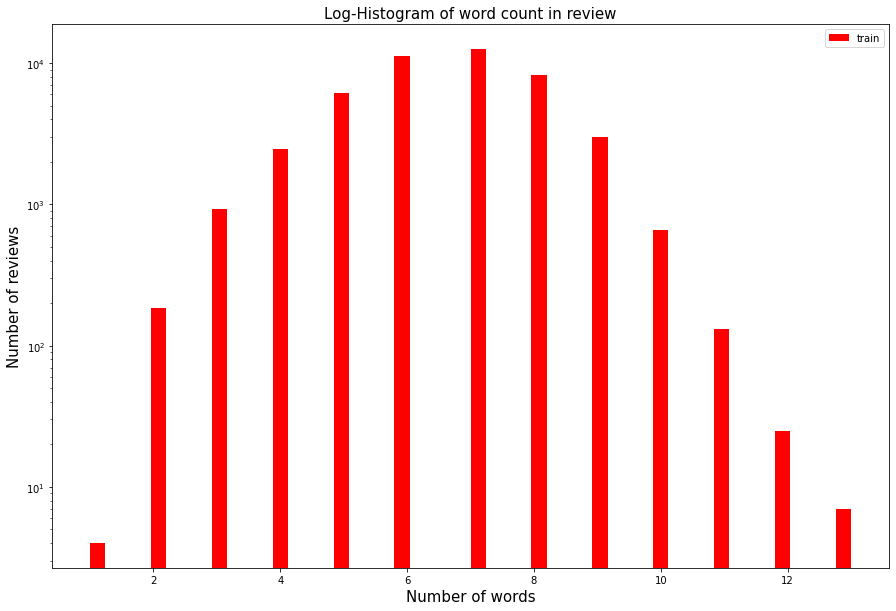

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
plt.hist(train_word_counts, bins=50, facecolor='r',label='train')
plt.title('Log-Histogram of word count in review', fontsize=15)
plt.yscale('log', nonposy='clip')
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Number of reviews', fontsize=15)

In [ ]:
print('리뷰 단어 개수 최대 값: {}'.format(np.max(train_word_counts)))
print('리뷰 단어 개수 최소 값: {}'.format(np.min(train_word_counts)))
print('리뷰 단어 개수 평균 값: {:.2f}'.format(np.mean(train_word_counts)))
print('리뷰 단어 개수 표준편차: {:.2f}'.format(np.std(train_word_counts)))
print('리뷰 단어 개수 중간 값: {}'.format(np.median(train_word_counts)))
# 사분위의 대한 경우는 0~100 스케일로 되어있음
print('리뷰 단어 개수 제 1 사분위: {}'.format(np.percentile(train_word_counts, 25)))
print('리뷰 단어 개수 제 3 사분위: {}'.format(np.percentile(train_word_counts, 75)))

리뷰 단어 개수 최대 값: 13
리뷰 단어 개수 최소 값: 1
리뷰 단어 개수 평균 값: 6.59
리뷰 단어 개수 표준편차: 1.47
리뷰 단어 개수 중간 값: 7.0
리뷰 단어 개수 제 1 사분위: 6.0
리뷰 단어 개수 제 3 사분위: 8.0


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_train_review)
train_sequences = tokenizer.texts_to_sequences(clean_train_review)
test_sequences = tokenizer.texts_to_sequences(clean_test_review)

word_vocab = tokenizer.word_index # 단어 사전 형태


In [ ]:
data_configs = {}
data_configs['vocab'] = word_vocab
data_configs['vocab_size'] = len(word_vocab)

In [ ]:
MAX_SEQUENCE_LENGTH = 7 # 문장 최대 길이

train_inputs = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post') # 학습 데이터를 벡터화
train_labels = np.array(train['topic_idx']) # 학습 데이터의 라벨

test_inputs = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post') # 테스트 데이터를 벡터화
#test_labels = np.array(test['topic_idx']) # 테스트 데이터의 라벨

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import os
import json

from tqdm import tqdm

In [ ]:
model_name = 'cnn_classifier_kr'
BATCH_SIZE = 512
NUM_EPOCHS = 10
VALID_SPLIT = 0.1
MAX_LEN = train_inputs.shape[1]

kargs = {'model_name': model_name,
        'vocab_size': data_configs['vocab_size'],
        'embedding_size': 128,
        'num_filters': 100,
        'dropout_rate': 0.5,
        'hidden_dimension': 250,
        'output_dimension':1}

In [ ]:
class CNNClassifier(tf.keras.Model):
    
    def __init__(self, **kargs):
        super(CNNClassifier, self).__init__(name=kargs['model_name'])
        self.embedding = layers.Embedding(input_dim=kargs['vocab_size'],
                                     output_dim=kargs['embedding_size'])
        self.conv_list = [layers.Conv1D(filters=kargs['num_filters'],
                                   kernel_size=kernel_size,
                                   padding='valid',
                                   activation=tf.keras.activations.relu,
                                   kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
                     for kernel_size in [3,4,5]]
        self.pooling = layers.GlobalMaxPooling1D()
        self.dropout = layers.Dropout(kargs['dropout_rate'])
        self.fc1 = layers.Dense(units=kargs['hidden_dimension'],
                           activation=tf.keras.activations.relu,
                           kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
        self.fc2 = layers.Dense(units=kargs['output_dimension'],
                           activation=tf.keras.activations.sigmoid,
                           kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
    
    def call(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        x = tf.concat([self.pooling(conv(x)) for conv in self.conv_list], axis=-1)
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x

In [ ]:
model = CNNClassifier(**kargs)

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])

In [ ]:
# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001,patience=2)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)\

#checkpoint_path = DATA_OUT_PATH + model_name + '/weights.h5'
#checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
#if os.path.exists(checkpoint_dir):
#    print("{} -- Folder already exists \n".format(checkpoint_dir))
#else:
#    os.makedirs(checkpoint_dir, exist_ok=True)
#    print("{} -- Folder create complete \n".format(checkpoint_dir))
    

#cp_callback = ModelCheckpoint(
#    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

In [ ]:
history = model.fit(train_inputs, train_labels, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
                    validation_split=VALID_SPLIT, callbacks=[earlystop_callback])

Epoch 1/10
81/81 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.1345

InvalidArgumentError: ignored

# 코드공유 보고 적용해보기

In [ ]:
import pandas as pd
import numpy as np
import re

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import StratifiedKFold

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.optimizers import Adam

from keras.utils import np_utils

import warnings 
warnings.filterwarnings(action='ignore')

In [ ]:
train      = pd.read_csv("/content/drive/MyDrive/Dacon/뉴스 토픽 분류 AI 경진대회/data/train_data.csv")
test       = pd.read_csv("/content/drive/MyDrive/Dacon/뉴스 토픽 분류 AI 경진대회/data/test_data.csv")
submission = pd.read_csv("/content/drive/MyDrive/Dacon/뉴스 토픽 분류 AI 경진대회/data/sample_submission.csv")
topic_dict = pd.read_csv("/content/drive/MyDrive/Dacon/뉴스 토픽 분류 AI 경진대회/data/topic_dict.csv")

In [ ]:
stop_words = [ '은', '는', '이', '가', '하', '아', '것', '들','의', '있', '되', '수', '보', '주', '등', '한']
okt = Okt()

def clean_text(sent, okt, remove_stopwords = False, stop_words = []):
  sent_clean = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", " ", sent)
  
  word_sent = okt.morphs(sent_clean, stem=True)
    
  if remove_stopwords:
        
        # 불용어 제거(선택적)
    word_set = [token for token in word_sent if not token in stop_words]
    
  return word_sent


clean_train_review = []

for review in train['title']:
    # 비어있는 데이터에서 멈추지 않도록 string인 경우만 진행
    if type(review) == str:
        clean_train_review.append(clean_text(review, okt, remove_stopwords = True, stop_words=stop_words))
    else:
        clean_train_review.append([])  #string이 아니면 비어있는 값 추가

clean_test_review = []

for review in test['title']:
    # 비어있는 데이터에서 멈추지 않도록 string인 경우만 진행
    if type(review) == str:
        clean_test_review.append(clean_text(review, okt, remove_stopwords = True, stop_words=stop_words))
    else:
        clean_test_review.append([])  #string이 아니면 비어있는 값 추가


In [ ]:
X_train = np.array([x for x in clean_train_review])
X_test = np.array([x for x in clean_test_review])
Y_train = np.array([x for x in train['topic_idx']])

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)

(45654,)
(9131,)
(45654,)


In [ ]:
# Tokenizer
from keras.preprocessing.text import Tokenizer
vocab_size = 2000  

tokenizer = Tokenizer(num_words = vocab_size)  
  # Tokenizer 는 데이터에 출현하는 모든 단어의 개수를 세고 빈도 수로 정렬해서 
  # num_words 에 지정된 만큼만 숫자로 반환하고, 나머지는 0 으로 반환합니다                 
tokenizer.fit_on_texts(X_train) # Tokenizer 에 데이터 실제로 입력
sequences_train = tokenizer.texts_to_sequences(X_train)    # 문장 내 모든 단어를 시퀀스 번호로 변환
sequences_test = tokenizer.texts_to_sequences(X_test)      # 문장 내 모든 단어를 시퀀스 번호로 변환

print(len(sequences_train), len(sequences_test))

45654 9131


In [ ]:
# 변환된 시퀀스 번호를 이용해 단어 임베딩 벡터 생성
word_index = tokenizer.word_index

In [ ]:
# 독립변수 데이터 전처리
  ## 문장의 길이기 제각각이기 때문에 벡터 크기 다 다름
  ## 그러므로 최대 시퀀스 길이 크기(211) 만큼 넉넉하게 늘리고
  ## 패딩(padding) 작업을 통해 나머지 빈 공간을 0으로 채움
max_length = 14    # 위에서 그래프 확인 후 정함
padding_type='post'

train_x = pad_sequences(sequences_train, padding='post', maxlen=max_length)
test_x = pad_sequences(sequences_test, padding=padding_type, maxlen=max_length)

print(train_x.shape, test_x.shape)

(45654, 14) (9131, 14)


In [ ]:
# 종속변수 데이터 전처리
train_y = np_utils.to_categorical(Y_train) # Y_train 에 원-핫 인코딩 왜냐? 7개로 분류되어야 하니까?
print(train_y)
print(train_y.shape)

[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]
(45654, 7)


In [ ]:
#파라미터 설정
vocab_size = 2000 # 제일 많이 사용하는 사이즈
embedding_dim = 200  
max_length = 14    # 위에서 그래프 확인 후 정함
padding_type='post'
#oov_tok = "<OOV>"

In [ ]:
# 양방향 LSTM 레이어를 사용한 모델 (model3) 정의
model3 = Sequential([Embedding(vocab_size, embedding_dim, input_length =max_length),
        tf.keras.layers.Bidirectional(LSTM(units = 64, return_sequences = True)),
        tf.keras.layers.Bidirectional(LSTM(units = 64, return_sequences = True)),
        tf.keras.layers.Bidirectional(LSTM(units = 64)),
        Dense(7, activation='softmax')    # 결과값이 0~6 이므로 Dense(7)
    ])
    
model3.compile(loss= 'categorical_crossentropy', #여러개 정답 중 하나 맞추는 문제이므로 손실 함수는 categorical_crossentropy
              optimizer= 'adam',
              metrics = ['accuracy']) 
model3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 14, 200)           400000    
_________________________________________________________________
bidirectional (Bidirectional (None, 14, 128)           135680    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 14, 128)           98816     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_4 (Dense)              (None, 7)                 903       
Total params: 734,215
Trainable params: 734,215
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 계층 교차 검증
n_fold = 5  
seed = 42

cv = StratifiedKFold(n_splits = n_fold, shuffle=True, random_state=seed)

# 테스트데이터의 예측값 담을 곳 생성
test_y = np.zeros((test_x.shape[0], 7))

# 조기 종료 옵션 추가
es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3,
                   verbose=1, mode='min', baseline=None, restore_best_weights=True)

for i, (i_trn, i_val) in enumerate(cv.split(train_x, Y_train), 1):
    print(f'training model for CV #{i}')

    model3.fit(train_x[i_trn], 
            to_categorical(Y_train[i_trn]),
            validation_data=(train_x[i_val], to_categorical(Y_train[i_val])),
            epochs=10,
            batch_size=512,
            callbacks=[es])     # 조기 종료 옵션
                      
    test_y += model3.predict(test_x) / n_fold    # 나온 예측값들을 교차 검증 횟수로 나눈다

training model for CV #1
Epoch 1/10
72/72 [==============================] - 5s 70ms/step - loss: 1.2320 - accuracy: 0.5419 - val_loss: 0.7006 - val_accuracy: 0.7667
Epoch 2/10
72/72 [==============================] - 2s 25ms/step - loss: 0.6265 - accuracy: 0.7926 - val_loss: 0.6550 - val_accuracy: 0.7789
Epoch 3/10
72/72 [==============================] - 2s 25ms/step - loss: 0.5586 - accuracy: 0.8155 - val_loss: 0.6368 - val_accuracy: 0.7864
Epoch 4/10
72/72 [==============================] - 2s 25ms/step - loss: 0.5242 - accuracy: 0.8259 - val_loss: 0.6335 - val_accuracy: 0.7882
Epoch 5/10
72/72 [==============================] - 2s 25ms/step - loss: 0.4970 - accuracy: 0.8336 - val_loss: 0.6391 - val_accuracy: 0.7850
Epoch 6/10
72/72 [==============================] - 2s 31ms/step - loss: 0.4785 - accuracy: 0.8397 - val_loss: 0.6467 - val_accuracy: 0.7805
Epoch 7/10
72/72 [==============================] - 2s 24ms/step - loss: 0.4579 - accuracy: 0.8450 - val_loss: 0.6505 - val_accur

In [ ]:
test_y

array([[0.10633929, 0.01874498, 0.2898702 , ..., 0.04264535, 0.01831621,
        0.03279842],
       [0.0028652 , 0.00111238, 0.00766978, ..., 0.00331375, 0.00294959,
        0.00128776],
       [0.0627812 , 0.16869833, 0.5520696 , ..., 0.06018202, 0.02116093,
        0.11254156],
       ...,
       [0.02657679, 0.01272516, 0.3800051 , ..., 0.39610771, 0.02287034,
        0.03046742],
       [0.54923321, 0.18606577, 0.22068637, ..., 0.03442936, 0.00101448,
        0.00582581],
       [0.01021994, 0.00411357, 0.49851903, ..., 0.01546255, 0.00326424,
        0.45743244]])

In [ ]:
topic = []
for i in range(len(test_y)):
    topic.append(np.argmax(test_y[i]))

In [ ]:
submission['topic_idx'] = topic
submission

,index,topic_idx
0,45654,3
1,45655,3
2,45656,2
3,45657,2
4,45658,3
...,...,...
9126,54780,3
9127,54781,6
9128,54782,4
9129,54783,0


In [ ]:
submission.to_csv('/content/drive/MyDrive/Dacon/뉴스 토픽 분류 AI 경진대회/submission/LSTM1.csv', index=False)

#LB Score : 0.7621

#Bert 도전

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.5MB 7.4MB/s 
     |████████████████████████████████| 3.3MB 49.5MB/s 


In [ ]:
!pip install sentencepiece

In [ ]:
import os
import re
import numpy as np
from tqdm import tqdm

import tensorflow as tf
from transformers import BertModel, TFBertModel

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
train      = pd.read_csv("/content/drive/MyDrive/Dacon/뉴스 토픽 분류 AI 경진대회/data/train_data.csv")
test       = pd.read_csv("/content/drive/MyDrive/Dacon/뉴스 토픽 분류 AI 경진대회/data/test_data.csv")
submission = pd.read_csv("/content/drive/MyDrive/Dacon/뉴스 토픽 분류 AI 경진대회/data/sample_submission.csv")
topic_dict = pd.read_csv("/content/drive/MyDrive/Dacon/뉴스 토픽 분류 AI 경진대회/data/topic_dict.csv")

In [ ]:
train.iloc[0,2]

4

In [ ]:
class daconDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        text = self.df.iloc[idx, 1]
        label = self.df.iloc[idx, 2]
        return text, label

In [ ]:
train_dataset = daconDataset(train)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=2)

In [ ]:
device = torch.device("cuda")
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased')
model.to(device)

100%|██████████| 714314041/714314041 [00:16<00:00, 43551949.01B/s]


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [ ]:
optimizer = Adam(model.parameters(), lr=1e-6)

itr = 1
p_itr = 500
epochs = 1
total_loss = 0
total_len = 0
total_correct = 0


model.train()
for epoch in range(epochs):
    
    for text, label in train_loader:
        optimizer.zero_grad()
        
        # encoding and zero padding
        encoded_list = [tokenizer.encode(t, add_special_tokens=True) for t in text]
        padded_list =  [e + [0] * (512-len(e)) for e in encoded_list]
        
        sample = torch.tensor(padded_list)
        sample, label = sample.to(device), label.to(device)
        labels = torch.tensor(label)
        outputs = model(sample, labels=labels)
        loss, logits = outputs

        pred = torch.argmax(F.softmax(logits), dim=1)
        correct = pred.eq(labels)
        total_correct += correct.sum().item()
        total_len += len(labels)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        if itr % p_itr == 0:
            print('[Epoch {}/{}] Iteration {} -> Train Loss: {:.4f}, Accuracy: {:.3f}'.format(epoch+1, epochs, itr, total_loss/p_itr, total_correct/total_len))
            total_loss = 0
            total_len = 0
            total_correct = 0

        itr+=1

RuntimeError: ignored

# ?

In [ ]:
# https://github.com/rshah204/Text-Analytics-20-Newsgroups-Dataset/blob/master/2.%20ProjectCodeNeuralNetwork.ipynb

#https://github.com/diegoschapira/CNN-Text-Classifier-using-Keras/blob/master/models.py

!pip install konlpy

In [ ]:
import pandas as pd
import numpy as np
import re

import seaborn as sns
import matplotlib.pyplot as plt
from konlpy.tag import Okt,Mecab

from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import StratifiedKFold

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.optimizers import Adam

from keras.utils import np_utils

import warnings 
warnings.filterwarnings(action='ignore')

In [ ]:
train      = pd.read_csv("/content/drive/MyDrive/Dacon/뉴스 토픽 분류 AI 경진대회/data/train_data.csv")
test       = pd.read_csv("/content/drive/MyDrive/Dacon/뉴스 토픽 분류 AI 경진대회/data/test_data.csv")
submission = pd.read_csv("/content/drive/MyDrive/Dacon/뉴스 토픽 분류 AI 경진대회/data/sample_submission.csv")
topic_dict = pd.read_csv("/content/drive/MyDrive/Dacon/뉴스 토픽 분류 AI 경진대회/data/topic_dict.csv")

In [ ]:
stop_words = [ '은', '는', '이', '가', '하', '아', '것', '들','의', '있', '되', '수', '보', '주', '등', '한']
okt = Okt()

def clean_text(sent, okt, remove_stopwords = False, stop_words = []):
  sent_clean = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", " ", sent)
  
  word_sent = okt.morphs(sent_clean, stem=True)
    
  if remove_stopwords:
        
        # 불용어 제거(선택적)
    word_set = [token for token in word_sent if not token in stop_words]
    
  return word_sent


clean_train_review = []

for review in train['title']:
    # 비어있는 데이터에서 멈추지 않도록 string인 경우만 진행
    if type(review) == str:
        clean_train_review.append(clean_text(review, okt, remove_stopwords = True, stop_words=stop_words))
    else:
        clean_train_review.append([])  #string이 아니면 비어있는 값 추가

clean_test_review = []

for review in test['title']:
    # 비어있는 데이터에서 멈추지 않도록 string인 경우만 진행
    if type(review) == str:
        clean_test_review.append(clean_text(review, okt, remove_stopwords = True, stop_words=stop_words))
    else:
        clean_test_review.append([])  #string이 아니면 비어있는 값 추가


In [ ]:
X_train = np.array([x for x in clean_train_review])
X_test = np.array([x for x in clean_test_review])
Y_train = np.array([x for x in train['topic_idx']])

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)

(45654,)
(9131,)
(45654,)


In [ ]:
# Tokenizer
from keras.preprocessing.text import Tokenizer
vocab_size = 2000   #일반적으로 2000으로 한다고 함

tokenizer = Tokenizer(num_words = vocab_size)  
  # Tokenizer 는 데이터에 출현하는 모든 단어의 개수를 세고 빈도 수로 정렬해서 
  # num_words 에 지정된 만큼만 숫자로 반환하고, 나머지는 0 으로 반환합니다                 
tokenizer.fit_on_texts(X_train) # Tokenizer 에 데이터 실제로 입력
sequences_train = tokenizer.texts_to_sequences(X_train)    # 문장 내 모든 단어를 시퀀스 번호로 변환
sequences_test = tokenizer.texts_to_sequences(X_test)      # 문장 내 모든 단어를 시퀀스 번호로 변환

print(len(sequences_train), len(sequences_test))

45654 9131


In [ ]:
# 변환된 시퀀스 번호를 이용해 단어 임베딩 벡터 생성
word_index = tokenizer.word_index

In [ ]:
text_embedding = np.zeros((len(word_index) +1,))
text_embedding
#for word, i in word_index.items():
#  text_embedding[i] = (word).vector

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
# 독립변수 데이터 전처리
  ## 문장의 길이기 제각각이기 때문에 벡터 크기 다 다름
  ## 그러므로 최대 시퀀스 길이 크기(211) 만큼 넉넉하게 늘리고
  ## 패딩(padding) 작업을 통해 나머지 빈 공간을 0으로 채움
max_length = 14    # 위에서 그래프 확인 후 정함
padding_type='post'

train_x = pad_sequences(sequences_train, padding='post', maxlen=max_length)
test_x = pad_sequences(sequences_test, padding=padding_type, maxlen=max_length)

print(train_x.shape, test_x.shape)

(45654, 14) (9131, 14)


In [ ]:
# 종속변수 데이터 전처리
train_y = np_utils.to_categorical(Y_train) # Y_train 에 원-핫 인코딩 왜냐? 7개로 분류되어야 하니까?
print(train_y)
print(train_y.shape)

[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]
(45654, 7)


In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Flatten, MaxPooling1D, Input, Concatenate
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split

embedding_dim = 200  #이게뭐지?
vocab_size = len(word_index) + 1
maxlen = 14
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=maxlen,weights=[embedding_matrix],trainable=False))
model.add(Conv1D(128, 7, activation='relu',padding='same'))
model.add(MaxPooling1D())
model.add(Conv1D(256, 5, activation='relu',padding='same'))
model.add(MaxPooling1D())
model.add(Conv1D(512, 3, activation='relu',padding='same'))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

#model1 = Sequential()
#model1.add(Dense(1500, input_dim=train_x.shape[1], activation = 'relu'))
#model1.add(Dense(7, activation = 'softmax'))
#model1.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

#esc = EarlyStopping(monitor = 'val_accuracy', min_delta=0, patience = 20, verbose = 1, mode = 'auto')
#cp = ModelCheckpoint(filepath="weights.hdf5", monitor = 'val_loss', verbose = 1, save_best_only = True)



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 14, 200)           5268600   
_________________________________________________________________
conv1d (Conv1D)              (None, 14, 128)           179328    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 7, 128)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 7, 256)            164096    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 3, 256)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 3, 512)            393728    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 1, 512)            0

In [ ]:
from sklearn.model_selection import StratifiedKFold

test_y = np.zeros((test_x.shape[0], 7))
cv = StratifiedKFold(n_splits = 5, shuffle=True)

es = EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=3,
                   verbose=1, mode='min', baseline=None, restore_best_weights=True)

for i, (i_trn, i_val) in enumerate(cv.split(train_x, Y_train), 1):
    print(f'training model for CV #{i}')

    model.fit(train_x[i_trn], 
            to_categorical(Y_train[i_trn]),
            validation_data=(train_x[i_val], to_categorical(Y_train[i_val])),
            epochs=100,
            batch_size=512,
            callbacks=[es])     # 조기 종료 옵션
                      
    test_y += model.predict(test_x) / 5    # 나온 예측값들을 교차 검증 횟수로 나눈다

#m1 = model1.fit(train_x, train_y, batch_size = 128, epochs = 500, callbacks = [esc, cp], validation_split = 0.2)

#history = model.fit(train_x, train_y,
#                    epochs=50,
#                    verbose=True,
#                    batch_size=128,
#                    validation_split = 0.2)

training model for CV #1
Epoch 1/100
72/72 [==============================] - 19s 31ms/step - loss: 0.6868 - accuracy: 0.1499 - val_loss: 0.6683 - val_accuracy: 0.1671
Epoch 2/100
72/72 [==============================] - 1s 14ms/step - loss: 0.6624 - accuracy: 0.1633 - val_loss: 0.6453 - val_accuracy: 0.1671
Epoch 3/100
72/72 [==============================] - 1s 19ms/step - loss: 0.6398 - accuracy: 0.1631 - val_loss: 0.6240 - val_accuracy: 0.1612
Epoch 4/100
72/72 [==============================] - 1s 13ms/step - loss: 0.6190 - accuracy: 0.1589 - val_loss: 0.6044 - val_accuracy: 0.1612
Epoch 5/100
72/72 [==============================] - 1s 14ms/step - loss: 0.5998 - accuracy: 0.1589 - val_loss: 0.5863 - val_accuracy: 0.1671
Epoch 6/100
72/72 [==============================] - 1s 14ms/step - loss: 0.5821 - accuracy: 0.1714 - val_loss: 0.5697 - val_accuracy: 0.1671
Restoring model weights from the end of the best epoch.
Epoch 00006: early stopping
training model for CV #2
Epoch 1/100
7

In [ ]:
embedding_dim = 200 
vocab_size = len(word_index) + 1
maxlen = 14
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

def LSTM(vocab_size, max_len = maxlen):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim ,weights = [embedding_matrix], input_length = max_len)) #임베딩 가중치 적용 코드
    model.add(SpatialDropout1D(0.3))
    model.add(LSTM(64))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu', kernel_regularizer = regularizers.l2(0.001)))
    model.add(Dense(7, activation='softmax'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')
    model.summary()
    return model


### 뇌 붕괴
### 딥러닝 잠시 스탑

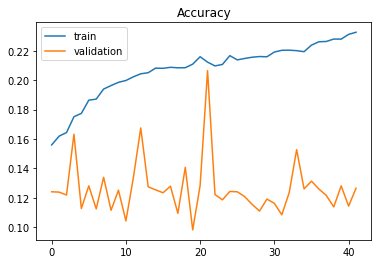

In [ ]:
plt.title('Accuracy')
plt.plot(m1.history['accuracy'], label='train')
plt.plot(m1.history['val_accuracy'], label='validation')
plt.legend()
plt.show();

In [ ]:
topic = []
for i in range(len(test_y)):
    topic.append(np.argmax(test_y[i]))

In [ ]:
yP1

array([[0.26163954, 0.13977483, 0.15247901, ..., 0.16493367, 0.10316532,
        0.07378481],
       [0.20208567, 0.05936033, 0.1695281 , ..., 0.09440192, 0.1300437 ,
        0.12063818],
       [0.11895926, 0.16817799, 0.12978442, ..., 0.15323606, 0.15385187,
        0.15366134],
       ...,
       [0.10576738, 0.16222091, 0.1375332 , ..., 0.16382594, 0.14401963,
        0.17480493],
       [0.08208287, 0.07688604, 0.2174914 , ..., 0.18256073, 0.21739747,
        0.1666636 ],
       [0.13138664, 0.20154898, 0.07913914, ..., 0.16207956, 0.13105403,
        0.18251295]], dtype=float32)

In [ ]:
# 양방향 LSTM 레이어를 사용한 모델 (model3) 정의
model = Sequential([Embedding(vocab_size, embedding_dim, input_length =max_length),
        tf.keras.layers.Bidirectional(LSTM(units = 64, return_sequences = True)),
        tf.keras.layers.Bidirectional(LSTM(units = 64, return_sequences = True)),
        tf.keras.layers.Bidirectional(LSTM(units = 64)),
        Dense(7, activation='softmax')    # 결과값이 0~4 이므로 Dense(5)
    ])
    
model.compile(loss= 'categorical_crossentropy', #여러개 정답 중 하나 맞추는 문제이므로 손실 함수는 categorical_crossentropy
              optimizer= 'adam',
              metrics = ['accuracy']) 
model.summary()

IndexError: ignored

In [ ]:
ar_train_x = np.array(train_x)
#ar_val_x = np.array(X_val)
ar_train_y = np.array(train_y)
#ar_val_y = np.array(y_val)
ar_test_x = np.array(test_x)